# Problem Set - Week 5
## Guillermo Trefogli

In [318]:
! pip install sktime
! pip install pmdarima

In [319]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sktime.forecasting.all import ForecastingHorizon
from sktime.forecasting.all import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

## 1. EDA

### 1.A 

In [320]:
df_co2 = pd.read_csv('hw5_data_co2.csv', parse_dates = ['ds'])
df_temp = pd.read_csv('hw5_data_temp.csv', parse_dates = ['ds'])

In [321]:
print(df_co2.isnull().sum())
print(df_temp.isnull().sum())

print(df_co2.shape)
print(df_temp.shape)

ds     0
co2    0
dtype: int64
ds      0
temp    0
dtype: int64
(735, 2)
(1674, 2)


In [322]:
from datetime import datetime, timedelta
df_co2['ds'] = df_co2['ds'] - timedelta(days=14)
df = pd.merge(df_co2, df_temp, how = "inner", on = "ds")
df

,ds,co2,temp
0,1958-03-01,315.700,57.38
1,1958-04-01,317.450,57.29
2,1958-05-01,317.510,57.32
3,1958-06-01,316.685,57.02
4,1958-07-01,315.860,57.27
...,...,...,...
730,2019-01-01,410.920,58.29
731,2019-02-01,411.660,58.37
732,2019-03-01,412.000,58.59
733,2019-04-01,413.510,58.50


### 1.B. 
- One dataset provides information for temperature, the other for CO2.
- There are no missing values in the dataset.
- Both variables are similar in terms of time series pattern: increasing trend over time.
- ACF plot shows autocorrelation in time for temperature

In [323]:
df.set_index('ds', inplace = True)
df

,co2,temp
ds,,
1958-03-01,315.700,57.38
1958-04-01,317.450,57.29
1958-05-01,317.510,57.32
1958-06-01,316.685,57.02
1958-07-01,315.860,57.27
...,...,...
2019-01-01,410.920,58.29
2019-02-01,411.660,58.37
2019-03-01,412.000,58.59


In [324]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
co2,735.0,354.210673,27.922811,313.20,328.785,351.34,376.515,414.83
temp,735.0,57.603293,0.397159,56.73,57.280,57.59,57.915,58.84


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


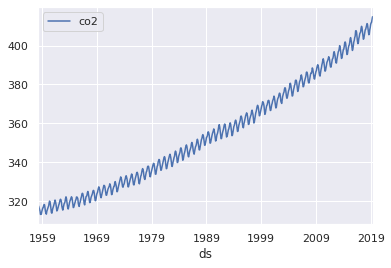

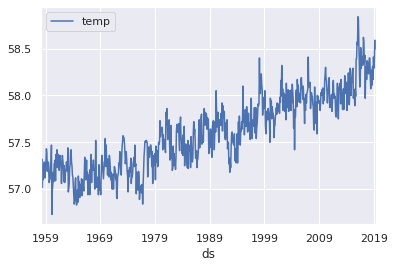

In [325]:
print(df[['co2']].plot())
print(df[['temp']].plot())

In [326]:
df.corr()

,co2,temp
co2,1.000000,0.898635
temp,0.898635,1.000000


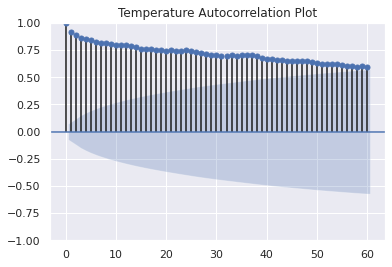

In [327]:
p = plot_acf(df['temp'], lags=60, title='Temperature Autocorrelation Plot')

## Part 2. ARIMA with external regressors

### 2.A. 
- Our variable of interest CO2 initially shows no stationarity:

    - **ADF test** is showing that **non-stationarity can be rejected**. The p-value in the test is lower than 0.05, which means that the null hypothesis of non-stationarity can be rejected.
    - **KPSS test** is showing that **stationarity in the time series can be rejected**. The p-value is smaller than 0.05, which means that the null hypothesis of stationarity in the time series can be rejected.

- Based on ACF and PACF, we can differentiate it to make the time series stational:

    - **ADF test** is showing that **non-stationarity can be rejected**. The p-value in the test is lower than 0.05, which means that the null hypothesis of non-stationarity can be rejected.
    - **KPSS test** is showing that **stationarity in the time series cannot be rejected**. The p-value is smaller than 0.05, which means that the null hypothesis of stationarity in the time series cannot be rejected.

- See below plots and tests outputs.

In [328]:
from statsmodels.tsa.statespace import sarimax
from statsmodels.tools.eval_measures import aicc
from sktime.transformations.series import boxcox
from sktime.forecasting.arima import ARIMA

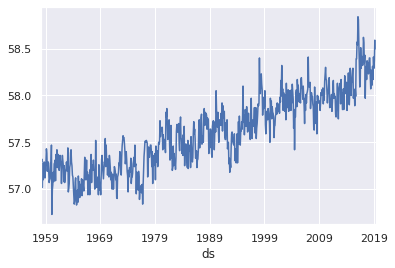

In [329]:
ts_temp = df.groupby(pd.PeriodIndex(df.index, freq="M"))['temp'].mean()
ts_temp.plot()

In [330]:
bctransformer = boxcox.BoxCoxTransformer()
ts_transf = bctransformer.fit_transform(ts_temp)

In [331]:
from sktime.forecasting.all import temporal_train_test_split
y_train, y_test = temporal_train_test_split(ts_temp)

In [332]:
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from copy import deepcopy

def adf_test(timeseries):
    print ('Dickey-Fuller Test Result:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#define KPSS
def kpss_test(timeseries, trend='c'):
    print ('KPSS Test Result:')
    kpsstest = kpss(timeseries, regression=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [333]:
adf_test(y_train)

Dickey-Fuller Test Result:
Test Statistic                  -2.481183
p-value                          0.120120
#Lags Used                       4.000000
Number of Observations Used    546.000000
Critical Value (1%)             -3.442384
Critical Value (5%)             -2.866848
Critical Value (10%)            -2.569597
dtype: float64


In [334]:
kpss_test(y_train)

KPSS Test Result:
Test Statistic            2.970537
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


### Differenting

In [335]:
y_train_seasdiff = y_train.diff(12).dropna()

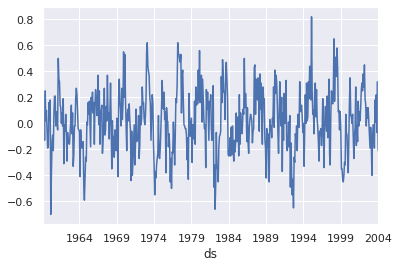

In [336]:
y_train_seasdiff.plot()
plt.show()

In [337]:
adf_test(y_train_seasdiff)

Dickey-Fuller Test Result:
Test Statistic                -7.250434e+00
p-value                        1.785978e-10
#Lags Used                     1.300000e+01
Number of Observations Used    5.250000e+02
Critical Value (1%)           -3.442867e+00
Critical Value (5%)           -2.867061e+00
Critical Value (10%)          -2.569710e+00
dtype: float64


In [338]:
kpss_test(y_train_seasdiff)

KPSS Test Result:
Test Statistic            0.044985
p-value                   0.100000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


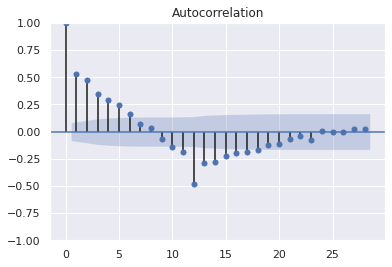

In [339]:
plot_acf(y_train_seasdiff)
plt.show()

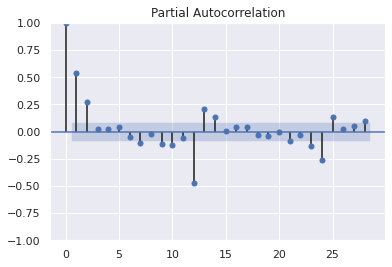

In [340]:
plot_pacf(y_train_seasdiff)
plt.show()

In [341]:
#y_train_nonseasdiff = np.diff(y_train_seasdiff)
y_train_nonseasdiff = y_train_seasdiff.diff(12).dropna()

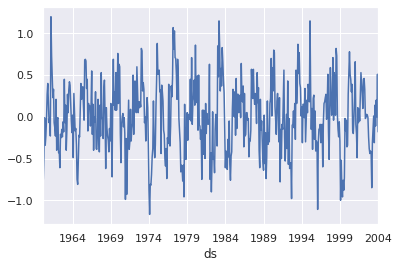

In [342]:
y_train_nonseasdiff.plot()
plt.show()

In [343]:
adf_test(y_train_nonseasdiff)

Dickey-Fuller Test Result:
Test Statistic                -7.555800e+00
p-value                        3.102015e-11
#Lags Used                     1.300000e+01
Number of Observations Used    5.130000e+02
Critical Value (1%)           -3.443162e+00
Critical Value (5%)           -2.867190e+00
Critical Value (10%)          -2.569780e+00
dtype: float64


In [344]:
kpss_test(y_train_nonseasdiff)

KPSS Test Result:
Test Statistic            0.009799
p-value                   0.100000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


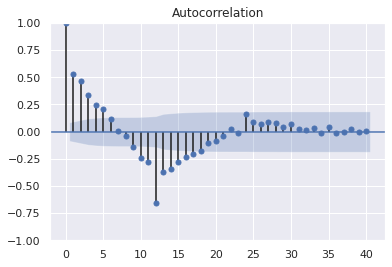

In [345]:
plot_acf(y_train_nonseasdiff, lags = 40)
plt.show()

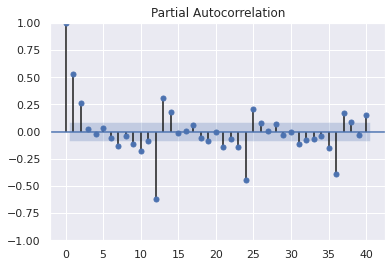

In [346]:
plot_pacf(y_train_nonseasdiff, lags = 40)
plt.show()

### 2.B. 

### ARIMA model:

In [347]:
sarima_model = sm.tsa.statespace.SARIMAX(endog=y_train,order=(3,1,1), seasonal_order=(0, 1, 0, 12))
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                  551
Model:             SARIMAX(3, 1, 1)x(0, 1, [], 12)   Log Likelihood                 117.304
Date:                             Sat, 14 May 2022   AIC                           -224.608
Time:                                     04:10:23   BIC                           -203.169
Sample:                                 03-31-1958   HQIC                          -216.222
                                      - 01-31-2004                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3835      0.045      8.587      0.000       0.296       0.471
ar.L2          0.2620      

In [348]:
print("AICc for order " + str(sarima_model.order) + str(sarima_model.seasonal_order) +": " +str(sarima_fit.aicc))

AICc for order (3, 1, 1)(0, 1, 0, 12): -224.49550706908607


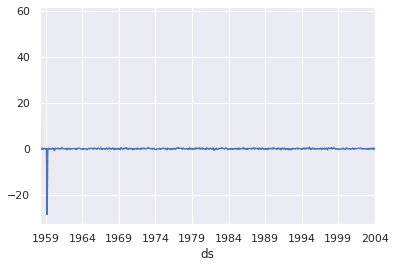

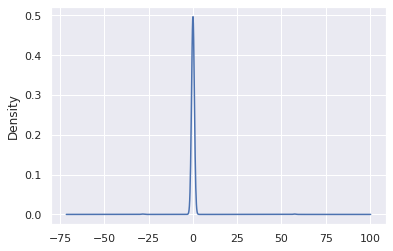

count    551.000000
mean       0.055174
std        2.739116
min      -28.550001
25%       -0.120285
50%       -0.000120
75%        0.125864
max       57.380000
dtype: float64


In [349]:
residuals = sarima_fit.resid
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

In [350]:
residuals

ds
1958-03    57.380000
1958-04    -0.089999
1958-05     0.030000
1958-06    -0.300000
1958-07     0.250000
             ...    
2003-09    -0.014296
2003-10     0.168874
2003-11    -0.167513
2003-12     0.283619
2004-01    -0.326205
Freq: M, Length: 551, dtype: float64

In [351]:
resid = residuals[24:]
resid

ds
1960-03   -0.797779
1960-04   -0.144174
1960-05    0.220645
1960-06    0.107033
1960-07   -0.110958
             ...   
2003-09   -0.014296
2003-10    0.168874
2003-11   -0.167513
2003-12    0.283619
2004-01   -0.326205
Freq: M, Length: 527, dtype: float64

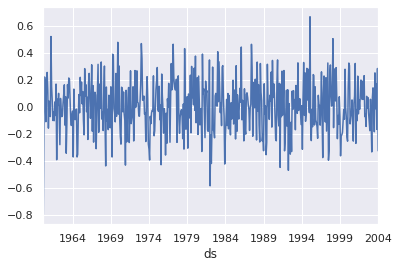

In [352]:
resid.plot()

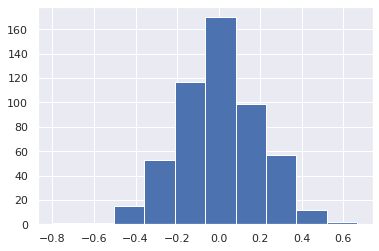

In [353]:
resid.hist()

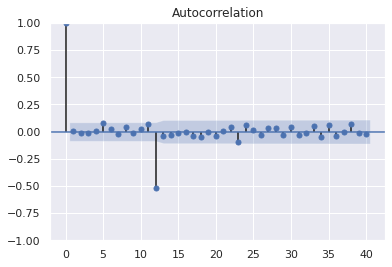

In [354]:
plot_acf(resid, lags = 40)
plt.show()

In [355]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,5.38012,0.864384,5.298779,0.870347


### AUTOarima model:

In [356]:
from sktime.forecasting.arima import AutoARIMA
from pmdarima.arima import auto_arima

In [357]:
y_train, y_test = temporal_train_test_split(ts_temp)

In [358]:
y_train.index.min(), y_train.index.max()

(Period('1958-03', 'M'), Period('2004-01', 'M'))

In [359]:
y_test.index.min(), y_test.index.max()

(Period('2004-02', 'M'), Period('2019-05', 'M'))

In [360]:
auto_arima = auto_arima(y_train, start_p=1, start_q=1,
                           max_p=10, max_q=10, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(auto_arima.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=8.55 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-53.968, Time=0.25 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-345.175, Time=1.38 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=6.73 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-167.230, Time=0.22 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-395.722, Time=2.11 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=15.00 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.50 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-284.630, Time=0.86 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-405.606, Time=1.59 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-353.561, Time=0.72 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.26 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.65 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-424.092, Time=2.02 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=-367.

In [361]:
print(auto_arima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  551
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood                 223.904
Date:                             Sat, 14 May 2022   AIC                           -433.808
Time:                                     04:13:25   BIC                           -403.793
Sample:                                          0   HQIC                          -422.067
                                             - 551                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0341      0.134      0.255      0.799      -0.228       0.296
ar.L2          0.0368      

Figure(864x576)


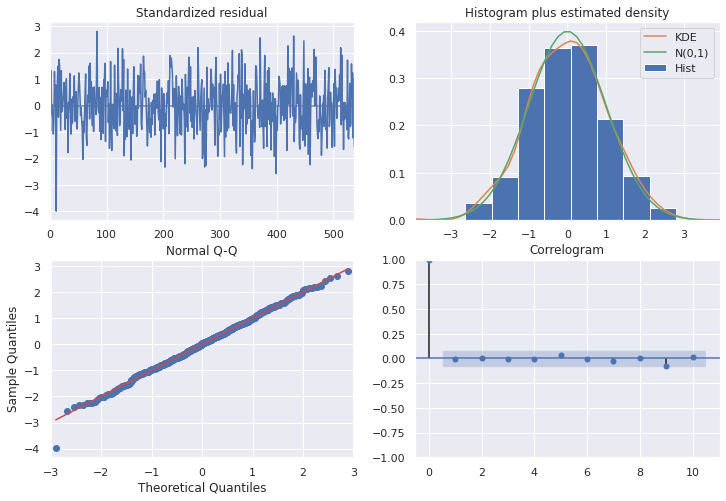

In [362]:
print(auto_arima.plot_diagnostics(figsize=(12,8)))

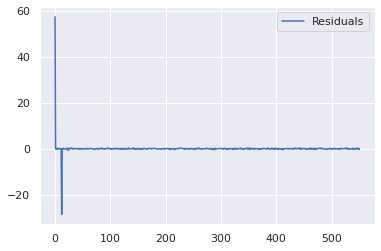

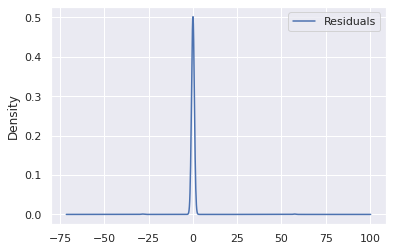

        Residuals
count  551.000000
mean     0.052828
std      2.736996
min    -28.550000
25%     -0.108642
50%      0.006010
75%      0.110697
max     57.380000


In [363]:
res = auto_arima.resid()
residuals = pd.DataFrame(res,columns=["Residuals"])
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [364]:
resid = residuals[24:]
resid

,Residuals
24,-0.763389
25,-0.015780
26,0.144974
27,0.252910
28,-0.074610
...,...
546,0.046744
547,0.194460
548,-0.193679
549,0.160406


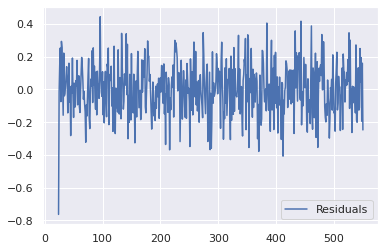

In [365]:
resid.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12a2233a10>]],
      dtype=object)

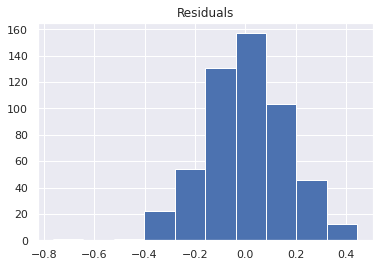

In [366]:
resid.hist()

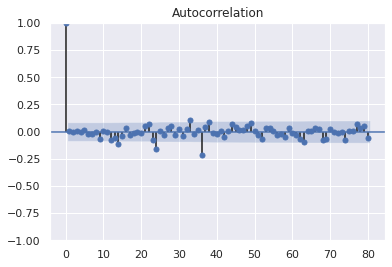

In [367]:
plot_acf(resid, lags = 80)
plt.show()

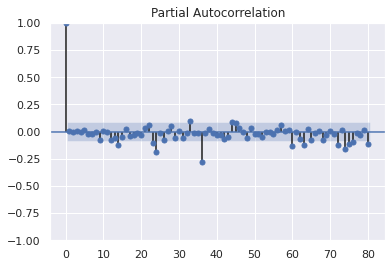

In [368]:
plot_pacf(resid, lags = 80)
plt.show()

In [369]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,3.571788,0.964604,3.501685,0.967041


### 2.C. 

In [370]:
y_pred = pd.DataFrame(auto_arima.predict(n_periods = len(y_test)), index = y_test.index)
y_pred.columns = ['pred']
y_pred

,pred
ds,
2004-02,58.028627
2004-03,58.108983
2004-04,57.984528
2004-05,58.084765
2004-06,57.916936
...,...
2019-01,58.553866
2019-02,58.521579
2019-03,58.595127


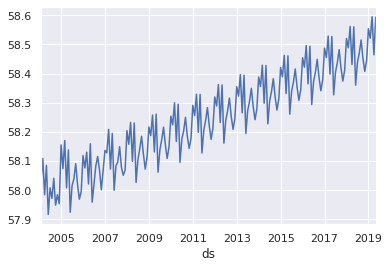

In [371]:
y_pred = y_pred.groupby(pd.PeriodIndex(y_pred.index, freq="M"))['pred'].mean()
y_pred.plot()

In [372]:
def plot_results(y_train, y_test, y_pred):
    # plot the results
    y_train.plot()
    y_test.plot()

    y_pred.plot()

    plt.legend(['y_train','y_test','y_pred'])
    plt.show()

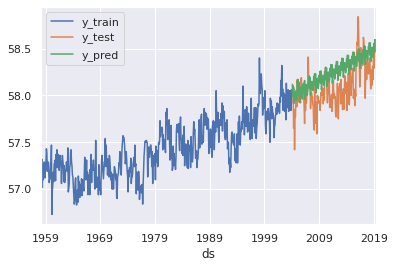

In [373]:
plot_results(y_train, y_test, y_pred)

In [374]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
smape = MeanAbsolutePercentageError(symmetric=True)
smape(y_test, y_pred)

0.003442278464427618

In [375]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
mase = MeanAbsoluteScaledError()
mase(y_test, y_pred, y_train=y_train)

1.5679160886858377

In [376]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
mae = MeanAbsoluteError()
mae(y_test, y_pred)

0.20012310804681058

In [377]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, y_pred)

0.06042945368794782

In [378]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError(symmetric=False)
mape(y_test, y_pred)

0.003450331712048208

### 2.D. 

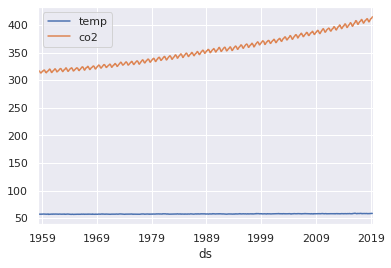

In [379]:
ts = df.groupby(pd.PeriodIndex(df.index, freq="M"))['temp', 'co2'].mean()
ts.plot()

In [380]:
y_train, y_test = temporal_train_test_split(ts)

In [381]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(endog=y_train['temp'],
                        exog = y_train['co2'],
                        order=(3,1,1),
                        trend='c',
                        seasonal_order=(2, 1, 0, 12))
sarimax_fit = sarimax_model.fit()
print(sarimax_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                temp   No. Observations:                  551
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood                 224.012
Date:                             Sat, 14 May 2022   AIC                           -430.023
Time:                                     04:13:45   BIC                           -391.433
Sample:                                 03-31-1958   HQIC                          -414.928
                                      - 01-31-2004                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.003      0.151      0.880      -0.005       0.006
co2           -0.0097      

In [382]:
print("AICc for order " + str(sarimax_model.order) + str(sarimax_model.seasonal_order) +": " +str(sarimax_fit.aicc))

AICc for order (3, 1, 1)(2, 1, 0, 12): -429.6824920506663


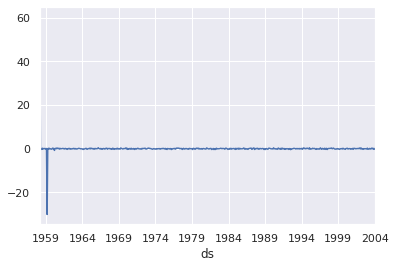

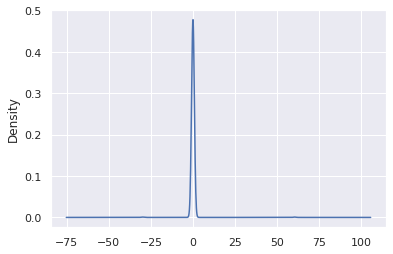

count    551.000000
mean       0.054703
std        2.882845
min      -30.081279
25%       -0.109683
50%        0.004615
75%        0.109658
max       60.445055
dtype: float64


In [383]:
# residual checks
# line plot of residuals
residuals = sarimax_fit.resid
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [384]:
residuals

ds
1958-03    60.445055
1958-04    -0.073209
1958-05     0.030382
1958-06    -0.308211
1958-07     0.241789
             ...    
2003-09     0.045396
2003-10     0.194082
2003-11    -0.197412
2003-12     0.155529
2004-01    -0.250193
Freq: M, Length: 551, dtype: float64

In [385]:
resid = residuals[24:]
resid

ds
1960-03   -0.760817
1960-04   -0.014800
1960-05    0.152592
1960-06    0.257897
1960-07   -0.072371
             ...   
2003-09    0.045396
2003-10    0.194082
2003-11   -0.197412
2003-12    0.155529
2004-01   -0.250193
Freq: M, Length: 527, dtype: float64

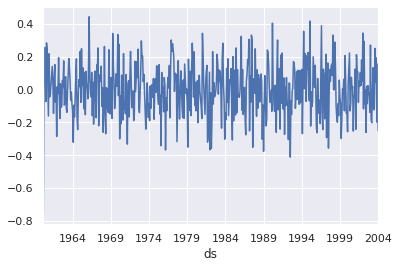

In [386]:
resid.plot()

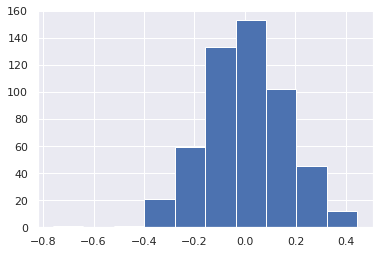

In [387]:
resid.hist()

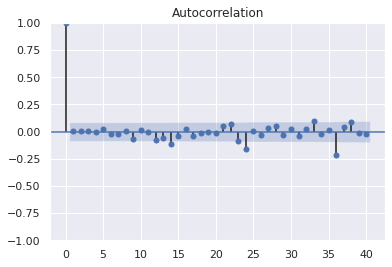

In [388]:
plot_acf(resid, lags = 40)
plt.show()

In [389]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,3.501347,0.967053,3.432918,0.969327


### 2.E. 

In [390]:
y_pred = sarimax_fit.forecast(steps = len(y_test['temp']),  exog=y_test['co2'])

In [391]:
y_train

,temp,co2
ds,,
1958-03,57.38,315.700
1958-04,57.29,317.450
1958-05,57.32,317.510
1958-06,57.02,316.685
1958-07,57.27,315.860
...,...,...
2003-09,58.02,372.980
2003-10,58.05,373.000
2003-11,57.84,374.350


In [392]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
smape = MeanAbsolutePercentageError(symmetric=True)
smape(y_test['temp'], y_pred)

0.005245846308345825

In [393]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
mae = MeanAbsoluteError()
mae(y_test['temp'], y_pred)

0.3055643484278933

In [394]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test['temp'], y_pred)

0.1277373148574044

In [395]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError(symmetric=False)
mape(y_test['temp'], y_pred)

0.005264456692487014

In [396]:
sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                temp   No. Observations:                  551
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood                 224.012
Date:                             Sat, 14 May 2022   AIC                           -430.023
Time:                                     04:13:47   BIC                           -391.433
Sample:                                 03-31-1958   HQIC                          -414.928
                                      - 01-31-2004                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.003      0.151      0.880      -0.005       0.006
co2           -0.0097      0.022     -0.446      0.655      -0.052       0.033
ar.L1          0.0165      0.146      0.113      0.910      -0.270       0.303
ar.L2          0.0278      0.089      0.314      0.753      -0.146       0.202
ar.L3         -0.1175      0.061     -1.915      0.056      -0.238       0.003
ma.L1         -0.5834      0.140     -4.155      0.000      -0.859      -0.308
ar.S.L12      -0.7436      0.041    -18.355      0.000      -0.823      -0.664
ar.S.L24      -0.3330      0.040     -8.241      0.000      -0.412      -0.254
sigma2         0.0251      0.002     16.587      0.000       0.022       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.92   Prob(JB):                         0.75
Heteroskedasticity (H):               1.13   Skew:                            -0.07
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Part 3. Prophet with additional regressors

### 3.A. 

In [397]:
! pip install pystan --user
! pip install fbprophet --user

In [398]:
! pip install wbdata

In [399]:
from util_prophet import *
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

In [400]:
y_train_prophet = y_train
y_train_prophet['ds'] = y_train_prophet.index
y_train_prophet.rename(columns={'temp':'y'}, inplace=True)

y_test_prophet = y_test
y_test_prophet['ds'] = y_test_prophet.index
y_test_prophet.rename(columns={'temp':'y'}, inplace=True)

In [401]:
y_train_prophet

,y,co2,ds
ds,,,
1958-03,57.38,315.700,1958-03
1958-04,57.29,317.450,1958-04
1958-05,57.32,317.510,1958-05
1958-06,57.02,316.685,1958-06
1958-07,57.27,315.860,1958-07
...,...,...,...
2003-09,58.02,372.980,2003-09
2003-10,58.05,373.000,2003-10
2003-11,57.84,374.350,2003-11


In [402]:
y_train_prophet['ds'] = y_train_prophet['ds'].dt.strftime('%Y-%m').add('-01 00:00:00.000')
print(y_train_prophet)

             y      co2                       ds
ds                                              
1958-03  57.38  315.700  1958-03-01 00:00:00.000
1958-04  57.29  317.450  1958-04-01 00:00:00.000
1958-05  57.32  317.510  1958-05-01 00:00:00.000
1958-06  57.02  316.685  1958-06-01 00:00:00.000
1958-07  57.27  315.860  1958-07-01 00:00:00.000
...        ...      ...                      ...
2003-09  58.02  372.980  2003-09-01 00:00:00.000
2003-10  58.05  373.000  2003-10-01 00:00:00.000
2003-11  57.84  374.350  2003-11-01 00:00:00.000
2003-12  58.06  375.690  2003-12-01 00:00:00.000
2004-01  57.92  376.790  2004-01-01 00:00:00.000

[551 rows x 3 columns]


In [403]:
model = Prophet()
model.fit(y_train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [422]:
future_data = model.make_future_dataframe(periods=len(y_test_prophet), freq='m')

In [423]:
forecast_data = model.predict(future_data)
forecast_data.iloc[0:3].T

,0,1,2
ds,1958-03-01 00:00:00,1958-04-01 00:00:00,1958-05-01 00:00:00
trend,57.215189,57.215493,57.215787
yhat_lower,57.079284,57.061034,57.040625
yhat_upper,57.468917,57.448108,57.428112
trend_lower,57.215189,57.215493,57.215787
trend_upper,57.215189,57.215493,57.215787
additive_terms,0.062528,0.031737,0.020392
additive_terms_lower,0.062528,0.031737,0.020392
additive_terms_upper,0.062528,0.031737,0.020392
yearly,0.062528,0.031737,0.020392


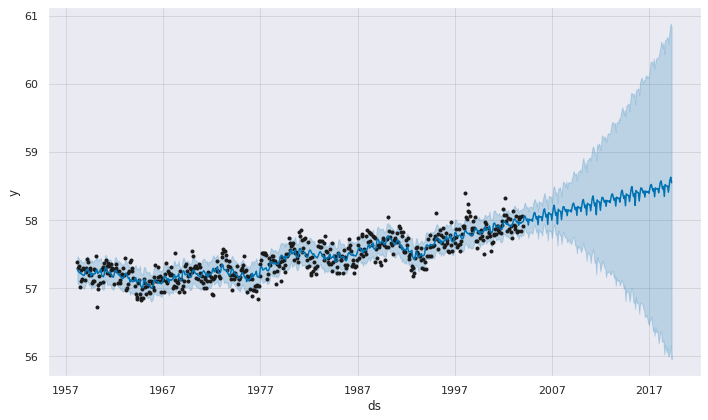

In [424]:
p = model.plot(forecast_data)

In [425]:
#forecast_data['ds']

0     1958-03-01
1     1958-04-01
2     1958-05-01
3     1958-06-01
4     1958-07-01
         ...    
730   2018-12-31
731   2019-01-31
732   2019-02-28
733   2019-03-31
734   2019-04-30
Name: ds, Length: 735, dtype: datetime64[ns]

In [421]:
#forecast_data.set_index('ds', inplace = True)

KeyError: ignored

In [426]:
forecast_data

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1958-03-01,57.215189,57.079284,57.468917,57.215189,57.215189,0.062528,0.062528,0.062528,0.062528,0.062528,0.062528,0.0,0.0,0.0,57.277717
1,1958-04-01,57.215493,57.061034,57.448108,57.215493,57.215493,0.031737,0.031737,0.031737,0.031737,0.031737,0.031737,0.0,0.0,0.0,57.247230
2,1958-05-01,57.215787,57.040625,57.428112,57.215787,57.215787,0.020392,0.020392,0.020392,0.020392,0.020392,0.020392,0.0,0.0,0.0,57.236179
3,1958-06-01,57.216091,57.033678,57.409110,57.216091,57.216091,0.007273,0.007273,0.007273,0.007273,0.007273,0.007273,0.0,0.0,0.0,57.223364
4,1958-07-01,57.216385,57.040420,57.419753,57.216385,57.216385,0.018871,0.018871,0.018871,0.018871,0.018871,0.018871,0.0,0.0,0.0,57.235255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,2018-12-31,58.493866,55.995002,60.590794,56.058165,60.687053,-0.084658,-0.084658,-0.084658,-0.084658,-0.084658,-0.084658,0.0,0.0,0.0,58.409208
731,2019-01-31,58.496772,56.021374,60.722300,56.024298,60.706419,0.011692,0.011692,0.011692,0.011692,0.011692,0.011692,0.0,0.0,0.0,58.508464
732,2019-02-28,58.499396,56.073146,60.827935,56.001594,60.726005,0.092830,0.092830,0.092830,0.092830,0.092830,0.092830,0.0,0.0,0.0,58.592226
733,2019-03-31,58.502302,56.163630,60.885166,55.980869,60.746802,0.127100,0.127100,0.127100,0.127100,0.127100,0.127100,0.0,0.0,0.0,58.629401


In [427]:
y_test_prophet

,y,co2,ds
ds,,,
2004-02,58.12,377.37,2004-02
2004-03,58.04,378.39,2004-03
2004-04,57.96,380.50,2004-04
2004-05,57.65,380.62,2004-05
2004-06,57.85,379.55,2004-06
...,...,...,...
2019-01,58.29,410.92,2019-01
2019-02,58.37,411.66,2019-02
2019-03,58.59,412.00,2019-03


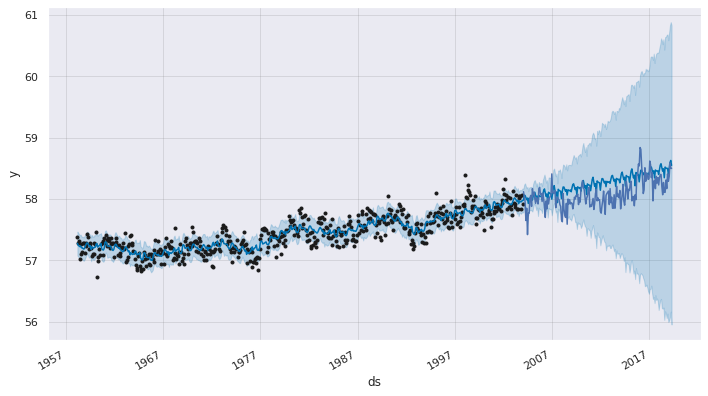

In [433]:
p = model.plot(forecast_data)
#plt.scatter(y_test_prophet['ds'],y_test_prophet['y'], color='r', marker='.')
#plt.show()
y_test_prophet['y'].plot()

In [434]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
smape = MeanAbsolutePercentageError(symmetric=True)
smape(y_test_prophet['y'], forecast_data)

ValueError: ignored

### 3.B. 

In [436]:
model_seasonal = Prophet(seasonality_prior_scale=10, changepoint_prior_scale=5)
model_seasonal.fit(y_train_prophet)
future_data_s = model_seasonal.make_future_dataframe(periods=len(y_test), freq='m')
forecast_data_s = model_seasonal.predict(future_data_s)
forecast_data_s.iloc[0:3].T

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,0,1,2
ds,1958-03-01 00:00:00,1958-04-01 00:00:00,1958-05-01 00:00:00
trend,57.258126,57.252792,57.247631
yhat_lower,57.12644,57.106863,57.086879
yhat_upper,57.495843,57.45507,57.445642
trend_lower,57.258126,57.252792,57.247631
trend_upper,57.258126,57.252792,57.247631
additive_terms,0.060569,0.030984,0.020538
additive_terms_lower,0.060569,0.030984,0.020538
additive_terms_upper,0.060569,0.030984,0.020538
yearly,0.060569,0.030984,0.020538


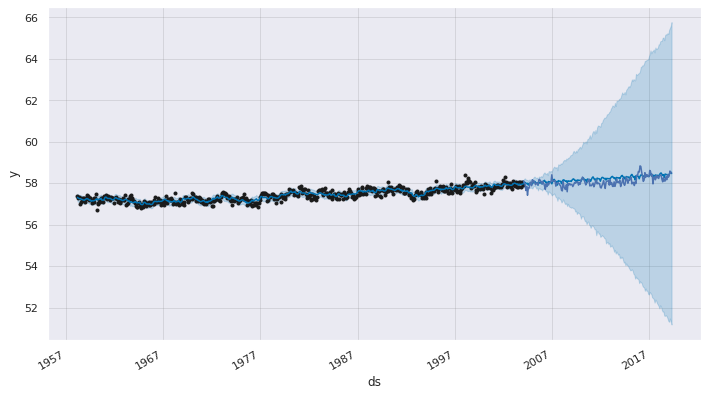

In [446]:
p_s = model_seasonal.plot(forecast_data_s)
y_test_prophet['y'].plot()

In [438]:
ind_s = forecast_data_s[forecast_data_s['ds'] == y_test.index[0]].index[0]
y_pred_s = forecast_data_s[ind:]['yhat']

IndexError: ignored

In [447]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
smape = MeanAbsolutePercentageError(symmetric=True)
smape(y_test_prophet['y'], forecast_data)

ValueError: ignored

### 3.C. 

In [440]:
y_train_prophet

,y,co2,ds
ds,,,
1958-03,57.38,315.700,1958-03-01 00:00:00.000
1958-04,57.29,317.450,1958-04-01 00:00:00.000
1958-05,57.32,317.510,1958-05-01 00:00:00.000
1958-06,57.02,316.685,1958-06-01 00:00:00.000
1958-07,57.27,315.860,1958-07-01 00:00:00.000
...,...,...,...
2003-09,58.02,372.980,2003-09-01 00:00:00.000
2003-10,58.05,373.000,2003-10-01 00:00:00.000
2003-11,57.84,374.350,2003-11-01 00:00:00.000


In [441]:
y_test_prophet

,y,co2,ds
ds,,,
2004-02,58.12,377.37,2004-02
2004-03,58.04,378.39,2004-03
2004-04,57.96,380.50,2004-04
2004-05,57.65,380.62,2004-05
2004-06,57.85,379.55,2004-06
...,...,...,...
2019-01,58.29,410.92,2019-01
2019-02,58.37,411.66,2019-02
2019-03,58.59,412.00,2019-03


In [442]:
def co2(ds):
    date = (pd.to_datetime(ds)).date()
    
    if y_train_prohet[date:].empty:
        return y_test_prohet[date:]['co2'].values[0]
    else:
        return (y_train_prophet[date:]['co2']).values[0]
    
    return 0

In [443]:
mr = Prophet(seasonality_prior_scale=10, changepoint_prior_scale=5)
mr.add_regressor('co2')
mr.fit(y_train_prophet)
future_r = mr.make_future_dataframe(periods=len(y_test_prophet), freq='m')
future_r['co2'] = future_r['ds'].apply(co2)
forecast_r = mr.predict(future_r)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NameError: ignored

In [444]:
forecast_r

NameError: ignored

In [445]:
ind_r = forecast_r[forecast_r['ds'] == y_test_prophet.index[0]].index[0]
y_pred_r = forecast_r[ind:]['yhat']

mae =  mean_absolute_error(y_pred_r, y_true)
mse = mean_squared_error(y_pred_r, y_true)
mape = mean_absolute_percentage_error(y_pred_r, y_true)
#smape = smape(np.array(y_pred_s), np.array(y_true))
mase = MeanAbsoluteScaledError(sp=12)
mase_val = mase(y_pred_r, y_true, y_train=y_train['y'])

print('Seasonal Arima errors')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
#print(f'SMAPE: {smape}')
print(f'MASE: {mase_val}')

NameError: ignored

### 3.D. 

Prophet model is the one with a better predictive power in contrast with previous models. Also, by adjusting per seasonality and changes points, and adding a external regressors we have the possibility of increasing the forecast performance of the fitted model.

## Part 4. Conclusion

### 4.A. 

According to performance metrics (MAE, MSE, MAPE, sMAPE, MASE), Prophet model is the one with a better predictive power. Also, we can increase the forecast power by adjusting per seasonality and changes points, and using external regressor it is possible to increase the forecast power of the fitted model.

### 4.B. 

If I had this data for 100 locations (different pairs of time series), I would apply multiple time series modeling using prophet. Also, I would take advantage of the options to fitt a model with a better performance, as by adjusting per seasonality and changes points, and adding external regressors.